In [ ]:
#@title Mount drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [169]:
#@title Filterwarnings
import warnings

warnings.filterwarnings('ignore')

# CNN architectures covid-19 chest image classification

In this assignment, we will learn how we can use CNN architectures for covid-19 chest image classification. Our task here will be a binary covid-19 chest image classification of kaggle datasets. 

We will use the `Kaggle` dataset for this programming, available on kaggle.

## Learning objective

- Use CNN architectures for real covid-19 chest image. 

## Dataset Description
Here, we are going to use the raw `COVID-19 Patients Lungs X Ray Images 10000`  data from kaggle. 
 
 **License** Data files © Original Authors <br>

**Citation:**
```
@Kaggle,
  url       = {https://www.kaggle.com/nabeelsajid917/covid-19-x-ray-10000-images?select=dataset}
}
```


### Load raw (provided) Dataset

Here we have provided dataset :

Corona positive : 70

Corona negative : 28

Dataset is generated using data augmentation.


# Data Augumentation

In [171]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from imutils import paths
import numpy as np
import cv2
import os

def data_augumentation(input_path, output_path):
    '''
    Augument the give data.

    ## Parameters:
      input_path (str) : input files path
      output_path (str) : output files path
    '''
    imagePaths = list(paths.list_images(input_path))
    data = []

    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2] 
        image = cv2.imread(imagePath)
        data.append(image)  

    for image in data:
        print("[INFO] loading example image...")
        image = img_to_array(image)
        image = np.expand_dims(image, axis = 0)
        aug = ImageDataGenerator(
            rotation_range = 30,
            zoom_range = 0.15,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.15,
            horizontal_flip = True,
            fill_mode = "nearest")
        total = 0
        print("[INFO] generating images...")
        imageGen = aug.flow(
            image,
            batch_size = 1,
            save_to_dir = output_path,
            save_prefix = "image",
            save_format = "jpg")  
        for image in imageGen:
            total += 1
            if total == 5:
                break

Covid postive and negative data augumentation

In [ ]:
Paths = [("/drive/My Drive/covid/raw/covid",
        "/drive/My Drive/covid/processed/covid"),
       ("/drive/My Drive/covid/raw/normal",
        "/drive/My Drive/covid/processed/normal")]
for i in Paths:
  data_augumentation(i[0],i[1])

### Load augumented (processed) Datasets

Here after augumentation we had saved augumented dataset into processed folder. Load augumented(processed) dataset.


In [173]:
def  get_data(input_path):
    '''
    Get data from given path.

    ## Parameters:
      input_path (str) : input files path

    ## Returns
       data (array) : image array
       labels (array) : label array
    '''
    imagePaths = list(paths.list_images(input_path))
    data = []
    labels = []

    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        data.append(image)
        labels.append(label)
    return data,labels

## Data preprocessing

In this section, you will complete a `data_preprocessing` function to clean the data and labels.

* Normalize all data dividing by 255.(i.e. convert image into binary image)

* Binarize the label using `LabelBinarizer()` 

* Convert binarizerd labels into categorical vectors.


In [174]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

def data_preprocessing(data,labels):
    '''
    Preprocess the given data.

    ## Parameters:
      data (array) : input image dataset
      labels (array) : array of labels

    ## Returns
       data (array) : processed array of images
       labels (array) : processd array of labels
    '''
    data = np.array(data) / 255.0
    labels = np.array(labels)
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)

    return data,labels,lb

## Train-Test split

We use sklearn ```train_test_split``` function to split data into train and test.



In [96]:
from sklearn.model_selection import train_test_split


def data_split(data,labels):

    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
    
    return (trainX, testX, trainY, testY)

In [97]:
input_path = "/drive/My Drive/covid/processed"
data,labels = get_data(input_path)
data,labels,lb = data_preprocessing(data,labels)
(trainX, testX, trainY, testY) = data_split(data,labels)

[INFO] loading images...


## Create models

### VGG16

In [151]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class Model_VGG16:
    def __init__(self,int_lr,epochs,bs):

        self.int_lr = int_lr # learning rate
        self.epochs = epochs
        self.bs = bs
        baseModel = VGG16(weights="imagenet", include_top=False,
                          input_tensor=Input(shape=(128, 128, 3)))

        headModel = baseModel.output
        headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(64, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(2, activation="softmax")(headModel)
        self.model = Model(inputs=baseModel.input, outputs=headModel)

        for layer in baseModel.layers:
            layer.trainable = False
        print("[INFO] compiling model...")
        opt = Adam(lr=self.int_lr, decay=self.int_lr / self.epochs)
        self.model.compile(loss="binary_crossentropy", optimizer=opt,
                      metrics=["accuracy"])
      
    def fit(self,trainX, trainY,testX,testY):
        trainAug = ImageDataGenerator(
            rotation_range=15,
            fill_mode="nearest")
        print("[INFO] training head...")
        History = self.model.fit_generator(
            trainAug.flow(trainX, trainY, batch_size=self.bs),
            steps_per_epoch=len(trainX) // self.bs,
            validation_data = (testX, testY),
            validation_steps=len(testX) // self.bs,
            epochs=self.epochs)
        return History

    def predict(self,testX):
         return self.model.predict(testX, batch_size=self.bs)

    def save_model(self):
        print("[INFO] saving COVID-19 detector model...")
        self.model.save("model.h5")

## Model evaluation

In [153]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def model_evaluation(History, predIdxs, lb,testX,testY):

    print("[INFO] evaluating network...")
    predIdxs = np.argmax(predIdxs, axis=1)
    print(classification_report(testY.argmax(axis=1), predIdxs,
                                target_names=lb.classes_))

    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    print(cm)
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    # plot the training loss and accuracy
    N = EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
    # plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
    # plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on COVID-19 Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

## ML pipeline

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS = 128
model_vgg16 = Model_VGG16(INIT_LR,EPOCHS,BS)
History = model_vgg16.fit(trainX, trainY,testX,testY)
predIdxs = model_vgg16.predict(testX)
#print(History.history.keys())

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        69
      normal       1.00      1.00      1.00        28

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

[[69  0]
 [ 0 28]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


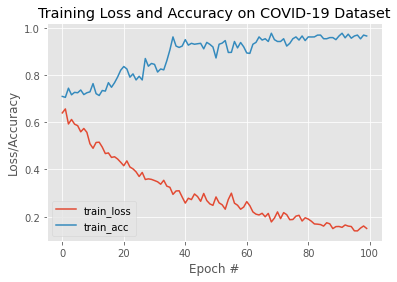

In [162]:
model_evaluation(History, predIdxs, lb,testX,testY)

# Key Note 
# Generator  are most
* Image generator
* fit_generator